---

##  2.3 策略迭代法的实现

- `策略迭代法`：

   在根据策略行动最终到达目标时，那种更快到达目标的策略下所执行的动作（action）是更重要的，可以对策略进行更新，以后更多地采用这一行动。换句话说，这是一项强调成功案例动作的行动方案.
- `价值迭代法`：

   从目标反向计算在目标的前一步、前两步的位置（状态）等，一步步引导智能体的行为。换句话说，它是一种给目标以外的位置（状态）也附加价值（优先级）的行动方案。

### 2.3.1 `策略迭代法`与`价值迭代法`

`策略梯度法`（policy gradient method）是`策略迭代法`的一种具体算法。

`softmax函数`是机器学习、深度学习中经常使用的函数：

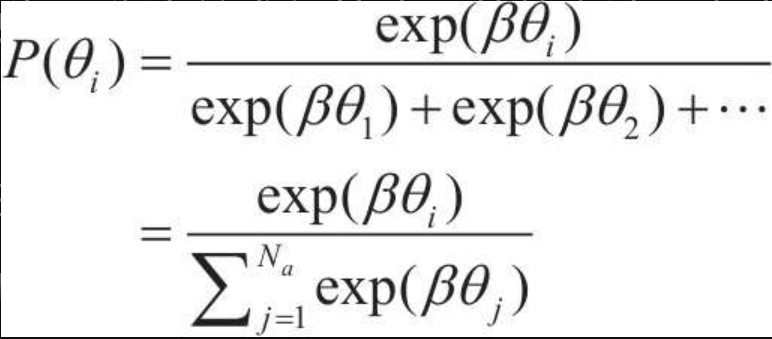

其中`Na`表示可以选择的动作类型的总数。

---

### 2.3.2 根据`策略梯度法`移动智能体

In [14]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

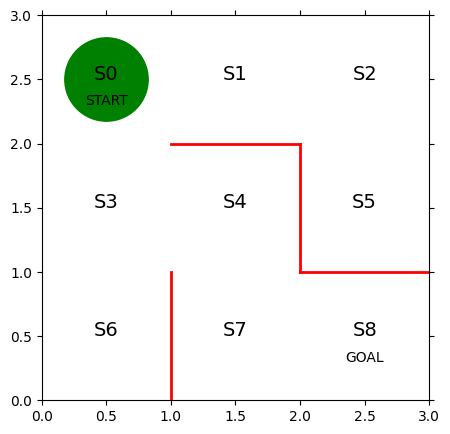

In [15]:
# 声明图的大小及图的变量名
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 画出红色的墙壁
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 画出表示状态的文字 S0~S8
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 设定画图的范围
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 当前位置S0用绿色圆圈画出
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [16]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8是目标
                    ])

前三个代码片段与之前相同。

以下计算比率的代码片段从简单计算比率改成利用exp的softmax函数。

In [17]:
def softmax_convert_into_pi_from_theta(theta):
    '''根据softmax函数计算比率'''

    beta = 1.0
    [m, n] = theta.shape  # 求得theta的矩阵大小
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # 将theta转换为exp(theta)，即求指数
    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # 简单地计算比率

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # 用softmax计算比率

    pi = np.nan_to_num(pi)  # nan转换为0

    return pi

In [18]:
# 求得初始策略pi_0
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.   , 0.5  , 0.5  , 0.   ],
       [0.   , 0.5  , 0.   , 0.5  ],
       [0.   , 0.   , 0.5  , 0.5  ],
       [0.333, 0.333, 0.333, 0.   ],
       [0.   , 0.   , 0.5  , 0.5  ],
       [1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.5  , 0.5  , 0.   , 0.   ]])

In [19]:
# 定义求取动作a以及1步移动后的状态s的函数

def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # 根据概率pi[s,:]选择direction
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 向上移动时状态的数字减少3
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 向右移动时状态的数字增加1
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 向下移动时状态的数字增加3
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 向左移动时状态的数字减少1

    return [action, s_next]

In [20]:
# 定义求解迷宫问题的函数，它输出状态和动作


def goal_maze_ret_s_a(pi):
    s = 0  # 开始地点
    s_a_history = [[0, np.nan]]  # 记录智能体移动的列表

    while (1):  # 直至达到目标的路径
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 代入当前状态(即目前最后一个状态idnex=-1)的动作

        s_a_history.append([next_s, np.nan])
        # 代入下一个状态，由于还不知道其动作，用nan表示

        if next_s == 8:  # 达到目标地点则终止
            break
        else:
            s = next_s

    return s_a_history

In [21]:
# 在迷宫内朝目标移动
s_a_history = goal_maze_ret_s_a(pi_0)

print(s_a_history)
print("求解迷宫路径所需的步骤是 " + str(len(s_a_history) - 1))

[[0, 1], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 2], [6, 0], [3, 0], [0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 1], [4, 3], [3, 2], [6, 0], [3, 1], [4, 3], [3, 1], [4, 3], [3, 2], [6, 0], [3, 1], [4, 2], [7, 1], [8, nan]]
求解迷宫路径所需的步骤是 32


---

### 2.3.3 根据`策略梯度法`更新策略

策略梯度法中，参数theta根据以下公式更新

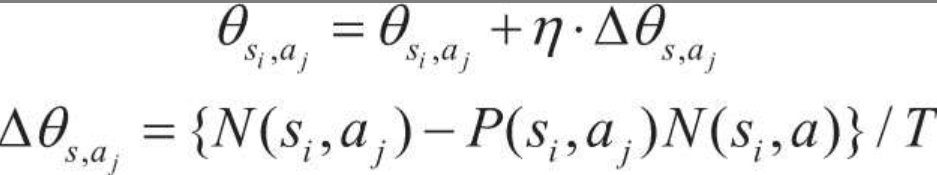

In [22]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学习率
    T = len(s_a_history) - 1  # 到达目标的总步数

    [m, n] = theta.shape  # theta矩阵的大小
    delta_theta = theta.copy()  # 生成初始的delta_theta，由于指针原因不能直接使用delta_theta=theta

    # 求取delta_theta的各元素
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # theta不是nan时

                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 从列表中取出状态i

                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 取出状态i下应该采取的动作j

                N_i = len(SA_i)  # 状态i下动作的总次数
                N_ij = len(SA_ij)  # 状态i下采取动作j的次数
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

In [23]:
# 策略更新
new_theta = update_theta(theta_0, pi_0, s_a_history)
print(new_theta)

pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[  nan 1.    1.      nan]
 [  nan 1.      nan 1.   ]
 [  nan   nan 1.002 0.998]
 [0.995 1.004 1.001   nan]
 [  nan   nan 0.997 1.003]
 [1.      nan   nan   nan]
 [1.      nan   nan   nan]
 [0.998 1.002   nan   nan]]
[[0.    0.5   0.5   0.   ]
 [0.    0.5   0.    0.5  ]
 [0.    0.    0.501 0.499]
 [0.332 0.335 0.334 0.   ]
 [0.    0.    0.498 0.502]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.499 0.501 0.    0.   ]]


In [24]:
# 策略梯度法求解迷宫问题

stop_epsilon = 10**-4  # 策略的变化小于10^-4则结束学习


theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:  # 重复执行，知道is_continue为False
    s_a_history = goal_maze_ret_s_a(pi)  # 由策略pi搜索迷宫探索历史
    new_theta = update_theta(theta, pi, s_a_history)  # 更新参数theta
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # 更新参数pi

    print(np.sum(np.abs(new_pi - pi)))  # 输出策略的变化
    print("求解迷宫问题所需的步数 " + str(len(s_a_history) - 1))

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

0.006111411651042842
求解迷宫问题所需的步数 180
0.015616487652926836
求解迷宫问题所需的步数 26
0.006224193480953433
求解迷宫问题所需的步数 32
0.04865275831818433
求解迷宫问题所需的步数 4
0.005832952130385982
求解迷宫问题所需的步数 54
0.02727595685205364
求解迷宫问题所需的步数 18
0.014441786088432662
求解迷宫问题所需的步数 38
0.006784545191580893
求解迷宫问题所需的步数 94
0.007329564653954679
求解迷宫问题所需的步数 142
0.011126257084350555
求解迷宫问题所需的步数 46
0.022602758483327323
求解迷宫问题所需的步数 14
0.009696446801272907
求解迷宫问题所需的步数 38
0.0072836951910919545
求解迷宫问题所需的步数 58
0.010722879506031846
求解迷宫问题所需的步数 66
0.0081631475246009
求解迷宫问题所需的步数 58
0.023734151895901445
求解迷宫问题所需的步数 8
0.0097640205099776
求解迷宫问题所需的步数 46
0.0400599317484821
求解迷宫问题所需的步数 6
0.02260336861327905
求解迷宫问题所需的步数 24
0.008653587091468296
求解迷宫问题所需的步数 146
0.013128980035013116
求解迷宫问题所需的步数 38
0.013393759172376674
求解迷宫问题所需的步数 36
0.014511102264017861
求解迷宫问题所需的步数 20
0.009488161780840498
求解迷宫问题所需的步数 52
0.0320250495594851
求解迷宫问题所需的步数 6
0.009120754993657165
求解迷宫问题所需的步数 42
0.018604432612696842
求解迷宫问题所需的步数 32
0.015204867372875852
求解迷宫问题所需的步数 28
0.0

In [25]:
# 确认最终的策略
np.set_printoptions(precision=3, suppress=True) # 设置为有效位数为3, 不显示指数
print(pi)

[[0.    0.014 0.986 0.   ]
 [0.    0.329 0.    0.671]
 [0.    0.    0.379 0.621]
 [0.011 0.978 0.012 0.   ]
 [0.    0.    0.985 0.015]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.015 0.985 0.    0.   ]]


In [26]:
# 将智能体移动的情形可视化

from matplotlib import animation
from IPython.display import HTML


def init():
    # 初始化背景图像
    line.set_data([], [])
    return (line,)


def animate(i):
    # 每一帧画面的内容
    state = s_a_history[i][0]  # 画出现在的场景
    x = (state % 3) + 0.5  # 状态的x坐标为状态除以3的余数加0.5
    y = 2.5 - int(state / 3)  # 状态的y坐标为2.5减去(状态数除以3)
    line.set_data(x, y)
    return (line,)


#　生成动画
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())

/var/folders/_8/lm2ssc4n6gbc7g4_wr4kf4740000gn/T/ipykernel_12344/1144856443.py:18: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
